In [1]:

try:
    import vrep
except:
    print ('--------------------------------------------------------------')
    print ('"vrep.py" could not be imported. This means very probably that')
    print ('either "vrep.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "vrep.py"')
    print ('--------------------------------------------------------------')
    print ('')

print ('Program started')
vrep.simxFinish(-1) # just in case, close all opened connections
clientID=vrep.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
if clientID!=-1:
    print ('Connected to remote API server')
    vrep.simxStartSimulation(clientID,vrep.simx_opmode_oneshot)
    res,leftHandle=vrep.simxGetObjectHandle(clientID,'leftM',vrep.simx_opmode_blocking)
    res,rightHandle=vrep.simxGetObjectHandle(clientID,'rightM',vrep.simx_opmode_blocking)


Program started
Connected to remote API server


In [2]:
%matplotlib inline
import time
import cv2
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML


In [ ]:
def set_classifier(cascPath):
    cascPath = cascPath
    faceCascade = cv2.CascadeClassifier(cascPath)
    return faceCascade
 
def count_item(classifier):
    count_item = 0
    for x in classifier: 
        count_item += 1
        if count_item >= 2:
            msg = 'Apenas uma face deve estar posicionada'
            return msg

def put_msg(msg,frame):
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0,0,255)
    cv2.putText(frame,msg,(10,10), font, 1,(255,255,255),2)

def set_nose_point(x,y,w,h,frame):
    #Marca ponto no nariz
    face_x = (x+(w/2))
    face_y = (y+(h/2))
    #Exibe ponto do nariz
    cv2.circle(frame,(face_x,face_y), 8, (0,255,0),-1)
        
def set_direction(x,y,ax,ay,stop):
    if(stop == True):
        return "STOP"
    else:
        if y < ay-precision_v: return "UP"
        elif y > ay+precision_v: return "DOWN"
        elif x < ax-precision_h: return "LEFT"
        elif x > ax+precision_h: return "RIGHT"

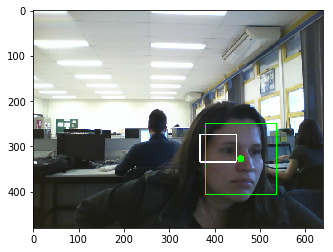

In [ ]:
#Variaveis de controle e configuracao
calc_average = True
count_face = 0 
average_x = 0 
average_y = 0 
precision_h = 40
precision_v = 30
sp=0
send_command = "STOP"
velocity = 0.5
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()  
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

while is_capturing:
    try:    # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frame = vc.read()
        frame = cv2.flip(frame,180) 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        #Set the Face Classifier
        faceCascade = set_classifier('haarcascade_frontalface_default.xml')
        #Set the Smile Classifier
        smileCascade = set_classifier('haarcascade_smile.xml')

        #Seta as configuracoes do classificador do ROSTO
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=8,
            minSize=(120, 120)
        )
         #Desenha um retangulo no rosto encontrado
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            set_nose_point(x,y,w,h,frame)
            
            #Define Region of Intereting do SORRISO
            roi_smile = frame[y:y+h, x:x+w]
            #Seta as configuracoes do classificador do SORRISO
            smile = smileCascade.detectMultiScale(
            roi_smile,
            scaleFactor=2.7,
            minNeighbors=20,
            minSize=(10, 10)  
            )
            #Cria retangulo do SORRISO
            for (sp,sq,sr,ss) in smile:
                cv2.rectangle(roi_smile,(sp,sq),(sp+sr,sq+ss), (255,0,0),1)
             #Verificar a parada com o sorriso
            if sp in smile:
                stop = True
            else:
                stop = False
            #Calibrando Local do Retangulo de Referencia
            if calc_average:

                count_face += 1
                average_x += (x+(w/2))
                average_y += (y+(h/2))
                progress = (count_face/60.0) * 100


                if count_face==3:
                    average_x /= count_face
                    average_y /= count_face

                    calc_average = False
            else:   

                face_x = (x+(w/2)) 
                face_y = (y+(h/2))
                flag_save = True
            
            
                #Cria quadrado em volta do nariz
                cv2.rectangle(frame, (average_x-precision_h,average_y-precision_v),
                                         (average_x+precision_h,average_y+precision_v), (255,255,255),thickness=2)
                               
                send_command = set_direction(face_x,face_y,average_x,average_y,stop)
                                      
                if(send_command == "UP"):
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,velocity,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,velocity,vrep.simx_opmode_oneshot)
                if(send_command == "RIGHT"):
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,velocity,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,-velocity,vrep.simx_opmode_oneshot)
                    time.sleep(0.5)
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,velocity,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,velocity,vrep.simx_opmode_oneshot)
                if(send_command == "LEFT"):
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,velocity,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,-velocity,vrep.simx_opmode_oneshot)
                    time.sleep(0.5)
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,velocity,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,velocity,vrep.simx_opmode_oneshot)
                if(send_command == "STOP"):
                    vrep.simxSetJointTargetVelocity(clientID,rightHandle,0,vrep.simx_opmode_oneshot)
                    vrep.simxSetJointTargetVelocity(clientID,leftHandle,0,vrep.simx_opmode_oneshot)
                                
        webcam_preview.set_data(frame)
        plt.draw()

        display.clear_output(wait=True)
        display.display(plt.gcf())

        #plt.pause(0.1)    # the pause time is = 1 / framerate
    except KeyboardInterrupt:
        vc.release()